In [2]:
import sys
sys.path.insert(0, "../../face-parsing.PyTorch")
from model import BiSeNet
sys.path.insert(0, "../../generative_inpainting")
import torch
import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import dlib
sys.path.insert(0, "../../deepfeatinterp")
import alignface

#################################### Face Parsing##############################################
class FaceParsing():
    def __init__(self, checkpoint):
        n_classes = 19
        self.net = BiSeNet(n_classes=n_classes)
        # net.cuda()
        self.net.load_state_dict(torch.load(checkpoint, map_location=torch.device('cpu')))
        self.net.eval()
        self.to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    def __inference(self, image):
        with torch.no_grad():
            cv2.imwrite("tmp.png", image)
            img = Image.open("tmp.png")
            image = img.resize((512, 512), Image.BILINEAR)
            img = self.to_tensor(image)
            img = torch.unsqueeze(img, 0)
            # img = img.cuda()
            out = self.net(img)[0]
            parsing = out.squeeze(0).cpu().numpy().argmax(0)
            return parsing
    
    def get_face_mask_512(self, image):
        assert image.shape[:2]==(512,512), f'Shape of input image should be 512x512'
        parsing_anno = self.__inference(image)
        vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
        num_of_class = np.max(vis_parsing_anno)


        facemask = np.zeros(image.shape)
        for pi in [1,2,3,4,5,6,7,8,9,10,11,12,13,17]:
            index = np.where(vis_parsing_anno == pi)
            facemask[index[0], index[1], :] = [255,255,255]
        return facemask
    
    def get_part_mask_by_id_512(self, image, id):
        assert image.shape[:2]==(512,512), f'Shape of input image should be 512x512'
        parsing_anno = self.__inference(image)
        vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
        num_of_class = np.max(vis_parsing_anno)


        facemask = np.zeros(image.shape)
        index = np.where(vis_parsing_anno == id)
        facemask[index[0], index[1], :] = [255,255,255]
        return facemask

    def get_face_mask_512_including_neck(self, image):
        assert image.shape[:2]==(512,512), f'Shape of input image should be 512x512'
        parsing_anno = self.__inference(image)
        vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
        num_of_class = np.max(vis_parsing_anno)


        facemask = np.zeros(image.shape)
        for pi in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,17]:
            index = np.where(vis_parsing_anno == pi)
            facemask[index[0], index[1], :] = [255,255,255]
        return facemask

    def get_face_mask(self, image, bbox, apply_dilation=True, includingneck=False):
        mask = np.zeros(image.shape)
        x1, y1, x2, y2 = map(int,bbox)
        crop = image[y1:y2, x1:x2]
        crop = cv2.resize(crop, (512, 512))
        if not includingneck:
            facemask_crop = self.get_face_mask_512(crop)
        else:
            facemask_crop = self.get_face_mask_512_including_neck(crop)

        facemask_crop = cv2.resize(facemask_crop, (x2-x1, y2-y1))
        mask[y1:y2, x1:x2] = facemask_crop

        if apply_dilation:
            kernel = np.ones((7,13),np.uint8)
            mask = cv2.dilate(mask,kernel,iterations = 5)

        return mask

    def get_part_mask_by_id(self, image, bbox, id, apply_dilation=True):
        mask = np.zeros(image.shape)
        x1, y1, x2, y2 = map(int,bbox)
        crop = image[y1:y2, x1:x2]
        crop = cv2.resize(crop, (512, 512))
        facemask_crop = self.get_part_mask_by_id_512(crop, id)
        facemask_crop = cv2.resize(facemask_crop, (x2-x1, y2-y1))
        mask[y1:y2, x1:x2] = facemask_crop

        if apply_dilation:
            kernel = np.ones((7,7),np.uint8)
            mask = cv2.dilate(mask,kernel,iterations = 5)
        
        return mask
    
    def paint_part_again(self, image, inpainted_image, bbox, part_id):
        part_mask = self.get_part_mask_by_id(image, bbox, part_id, apply_dilation=True)
        cv2.imwrite("neckmask.png", part_mask)
        assert image.shape == inpainted_image.shape
        inpainted_image[np.where(part_mask==255)] == image[np.where(part_mask==255)]

        index = np.where(part_mask==255)
        inpainted_image[index[0], index[1], :] = [255,255,255]

        cv2.imwrite("repaint.png", inpainted_image)
        cv2.imwrite("imageori.png", image)


        return inpainted_image

faceParsing = FaceParsing(checkpoint="../../face-parsing.PyTorch/res/cp/79999_iter.pth")
# img = cv2.imread("/home/vuthede/Desktop/obamafullframe.png")
# mask = faceParsing.get_face_mask(img, bbox=(400,50,800,400))
# plt.imshow(mask)
#################################### Face Parsing##############################################

####################################  Generative Inpaiinting #################################
import cv2
import tensorflow as tf
import neuralgym as ng
from inpaint_model import InpaintCAModel
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

class GenerativeInpainting():
   
    def __init__(self, checkpoint_dir, config):
        self.model = InpaintCAModel()
        self.checkpoint_dir = checkpoint_dir
        self.FLAGS = ng.Config(config)

    def inpaint(self, image, mask):
        assert image.shape == mask.shape

        h, w, _ = image.shape
        grid = 8
        image = image[:h//grid*grid, :w//grid*grid, :]
        mask = mask[:h//grid*grid, :w//grid*grid, :]

        image = np.expand_dims(image, 0)
        mask = np.expand_dims(mask, 0)
        input_image = np.concatenate([image, mask], axis=2)


        sess_config = tf.ConfigProto()
        # sess_config.gpu_options.allow_growth = True
        with tf.Session(config=sess_config) as sess:
            input_image = tf.constant(input_image, dtype=tf.float32)
            output = self.model.build_server_graph(self.FLAGS, input_image, reuse=tf.AUTO_REUSE)
            output = (output + 1.) * 127.5
            output = tf.reverse(output, [-1])
            output = tf.saturate_cast(output, tf.uint8)
            # load pretrained model
            vars_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
            assign_ops = []
            for var in vars_list:
                vname = var.name
                from_name = vname
                var_value = tf.contrib.framework.load_variable(self.checkpoint_dir, from_name)
                assign_ops.append(tf.assign(var, var_value))
            sess.run(assign_ops)
            print('Model loaded.')
            result = sess.run(output)
            return result[0]


inpainter = GenerativeInpainting(checkpoint_dir="../../generative_inpainting/model_logs/release_places2_256_deepfill_v2",
                               config="../../generative_inpainting/inpaint.yml")

####################################  Generative Inpaiinting #################################


def get_crop_bbox(img, x1,y1,x2,y2):
    return img[y1:y2, x1:x2]

model_path = "/home/vuthede/Downloads/shape_predictor_81_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_path)
def get_landmark(im1):
    det0 = detector(im1, 0)[0]
    shape = predictor(im1, det0)
    landmarks = np.matrix([[p.x, p.y] for p in shape.parts()])
    landmarks = np.array(landmarks)
    return landmarks


def align2D(img_in, img_ref):
    """
    Find transformation from ref-->in image
    and apply it to ref image 
    81 landmarks
    """

    lm1 = get_landmark(img_ref)
    lm2 = get_landmark(img_in)

    M,loss=alignface.fit_face_landmarks(lm1[:,::-1],lm2[:,::-1], landmarks=list(range(81)), scale_landmarks=[0,16],location_landmark=30,image_dims=img_in.shape[:2])

    warp_image = alignface.warp_to_template(img_ref,M,border_value=(0.5,0.5,0.5),image_dims=img_in.shape)


    r = cv2.boundingRect(np.float32(lm2))    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))

    return warp_image, center


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




---------------------------------- APP CONFIG ----------------------------------
num_gpus_per_job: 1
num_cpus_per_job: 4
num_hosts_per_job: 1
memory_per_job: 32
gpu_type: nvidia-tesla-p100
name: places2_gated_conv_v100
model_restore: 
dataset: celebahq
random_crop: False
val: False
log_dir: logs/full_model_celeba_hq_256
gan: sngan
gan_loss_alpha: 1
gan_with_mask: True
discounted_mask: True
random_seed: False
padding: SAME
train_spe: 4000
max_iters: 100000000
viz_max_out: 10
val_psteps: 2000
data_flist: 
  celebahq: ['data/celeba_hq/train_shuffled.flist', 'data/celeba_hq/validation_static_view.flist']
  celeba: ['data/celeba/t


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
ksizes is deprecated, use sizes instead
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model loaded.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)

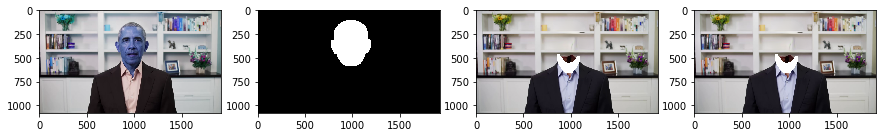

In [2]:

img = cv2.imread("./obamafullhd.png")
mask = faceParsing.get_face_mask(img, bbox=(685,85,1250,650), includingneck=False)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
mask = cv2.resize(mask, None, fx=0.5, fy=0.5)

result = inpainter.inpaint(img, mask)

img = cv2.resize(img, (1920,1080))
mask = cv2.resize(mask, (1920,1080) )
result = cv2.resize(result, (1920,1080))
result_with_reconstruct_neck = faceParsing.paint_part_again(img, result, bbox=(685,85,1250,650), part_id=14)




fig, ax = plt.subplots(1,4, figsize=(15,5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].imshow(result)
ax[3].imshow(result_with_reconstruct_neck)




In [3]:


def inpaint_face(img, bbox):
    # Get face mask
    x1,y1,x2,y2 = map(int, bbox)
    mask = faceParsing.get_face_mask(img, bbox=(x1,y1,x2,y2))
    
    # Inpaint face area
    # Resize a bit to inpaint, to reduce time
    img = cv2.resize(img, None, fx=0.5, fy=0.5)
    mask = cv2.resize(mask, None, fx=0.5, fy=0.5)
    result = inpainter.inpaint(img, mask)
    img = cv2.resize(img, None, fx=2, fy=2)
    mask = cv2.resize(mask, None, fx=2, fy=2)
    # result = cv2.resize(result, None, fx=2, fy=2)
    
    result = cv2.resize(result, (img.shape[1], img.shape[0]))

    return result[:,:,::-1]

def pipeline(img_hd, img_syn, bbox):
    # Inpaint face in Hd image
    img_hd_face_inpainted = inpaint_face(img_hd, bbox)
    x1,y1,x2,y2 = map(int, bbox)

    # Align 2D synthesis face to cropped HD face
    crophd = get_crop_bbox(img_hd, x1, y1, x2, y2)
    crophd = cv2.resize(crophd, (512,512))
    warp2d, center = align2D(crophd, img_syn)

    cv2.imshow("CropHd", crophd)
    cv2.imshow("warp2d", warp2d)

    warp2d_facemask = faceParsing.get_face_mask_512(warp2d).astype(np.uint8)
    
    crophd_inpainted = get_crop_bbox(img_hd_face_inpainted, x1, y1, x2, y2)
    cv2.imshow("Cropinpaint", crophd_inpainted)
    cv2.imshow("warp2d_facemask", warp2d_facemask)


    crophd_inpainted = cv2.resize(crophd_inpainted, (512,512))
    center = (center[0], center[1]-30)
    final_image = cv2.seamlessClone(warp2d, crophd_inpainted, warp2d_facemask, center, cv2.NORMAL_CLONE)
    # final_image = crophd_inpainted.copy()
    # final_image[np.where(warp2d_facemask==255)] = warp2d[np.where(warp2d_facemask==255)]
    final_image = final_image.astype(np.uint8)
    final_image = cv2.resize(final_image, (x2-x1, y2-y1))

    cv2.imshow("final_image", final_image)

    img_hd_face_inpainted[y1:y2, x1:x2] = final_image

    return img_hd_face_inpainted

def pipelineneckclone(img_hd, img_syn, bbox):
    # Inpaint face in Hd image
    img_hd_face_inpainted = inpaint_face(img_hd, bbox)
    x1,y1,x2,y2 = map(int, bbox)

    # Align 2D synthesis face to cropped HD face
    crophd = get_crop_bbox(img_hd, x1, y1, x2, y2)
    crophd = cv2.resize(crophd, (512,512))
    # warp2d, center = align2D(crophd, img_syn)
    img_syn = cv2.resize(img_syn, (512,512))

    warp2d = img_syn.copy()

    cv2.imshow("CropHd", crophd)
    cv2.imshow("warp2d", warp2d)

    warp2d_facemask = faceParsing.get_face_mask_512_including_neck(warp2d).astype(np.uint8)
    
    crophd_inpainted = get_crop_bbox(img_hd_face_inpainted, x1, y1, x2, y2)
    cv2.imshow("Cropinpaint", crophd_inpainted)
    cv2.imshow("warp2d_facemask", warp2d_facemask)


    crophd_inpainted = cv2.resize(crophd_inpainted, (512,512))
    # center = (center[0], center[1]-30)

    kernel = np.ones((7,7),np.uint8)
    warp2d_facemask = cv2.dilate(warp2d_facemask,kernel,iterations = 5)

    ray_image = cv2.cvtColor(warp2d_facemask, cv2.COLOR_BGR2GRAY)

    index = np.where(warp2d_facemask==255)[:2][::-1]
    xmin,ymin = np.min(index, axis=1)
    xmax,ymax = np.max(index, axis=1)
    center = ( (xmin+xmax)//2, (ymin+ymax)//2)
    # print(center)

    final_image = cv2.seamlessClone(warp2d, crophd_inpainted, warp2d_facemask, center, cv2.NORMAL_CLONE)
    # final_image = crophd_inpainted.copy()
    # final_image[np.where(warp2d_facemask==255)] = warp2d[np.where(warp2d_facemask==255)]
    final_image = final_image.astype(np.uint8)
    final_image = cv2.resize(final_image, (x2-x1, y2-y1))

    cv2.imshow("final_image", final_image)

    img_hd_face_inpainted[y1:y2, x1:x2] = final_image

    return img_hd_face_inpainted


def pipelineneck(img_hd, img_syn, bbox):
    # Inpaint face in Hd image
    img_hd_face_inpainted = inpaint_face(img_hd, bbox)
    x1,y1,x2,y2 = map(int, bbox)

    # Align 2D synthesis face to cropped HD face
    crophd = get_crop_bbox(img_hd, x1, y1, x2, y2)
    crophd = cv2.resize(crophd, (512,512))
    # warp2d, center = align2D(crophd, img_syn)
    img_syn = cv2.resize(img_syn, (512,512))

    warp2d = img_syn.copy()

    cv2.imshow("CropHd", crophd)
    cv2.imshow("warp2d", warp2d)

    warp2d_facemask = faceParsing.get_face_mask_512_including_neck(warp2d).astype(np.uint8)
    
    crophd_inpainted = get_crop_bbox(img_hd_face_inpainted, x1, y1, x2, y2)
    cv2.imshow("Cropinpaint", crophd_inpainted)
    cv2.imshow("warp2d_facemask", warp2d_facemask)


    crophd_inpainted = cv2.resize(crophd_inpainted, (512,512))
    # center = (center[0], center[1]-30)

    # kernel = np.ones((7,7),np.uint8)
    # warp2d_facemask = cv2.dilate(warp2d_facemask,kernel,iterations = 3)

    ray_image = cv2.cvtColor(warp2d_facemask, cv2.COLOR_BGR2GRAY)

    # index = np.where(warp2d_facemask==255)[:2]
    # xmin,ymin = np.min(index, axis=1)
    # xmax,ymax = np.max(index, axis=1)
    # center = ( (xmin+xmax)//2, (ymin+ymax)//2)
    # print(center)

    # final_image = cv2.seamlessClone(warp2d, crophd_inpainted, warp2d_facemask, center, cv2.NORMAL_CLONE)
    final_image = crophd_inpainted.copy()
    final_image[np.where(warp2d_facemask==255)] = warp2d[np.where(warp2d_facemask==255)]
    final_image = final_image.astype(np.uint8)
    final_image = cv2.resize(final_image, (x2-x1, y2-y1))

    cv2.imshow("final_image", final_image)

    img_hd_face_inpainted[y1:y2, x1:x2] = final_image

    return img_hd_face_inpainted
    


# Test demo

In [4]:
cap = cv2.VideoCapture("../result25072020mornign.mp4")
cap_hd = cv2.VideoCapture("../obama_fullhd.mp4")

bbox = [685,85,1250,650]
# cap.set(1, 30)
cap_hd.set(1, 2*60*30)


while True:
    ret, img = cap.read()
    ret2, img_hd = cap_hd.read()

    if not ret or not ret2:
        break

    result = pipelineneckclone(img_hd, img, bbox)

    cv2.imshow("synthesis: ", img)
    cv2.imshow("Result", result)

    k = cv2.waitKey(1)

    if k==27:
        break

cv2.destroyAllWindows()










Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
ksizes is deprecated, use sizes instead
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model loaded.
Model loaded.
Model loaded.
Model loaded.
Model loaded.
Model loaded.


# Playing around

[270 273]


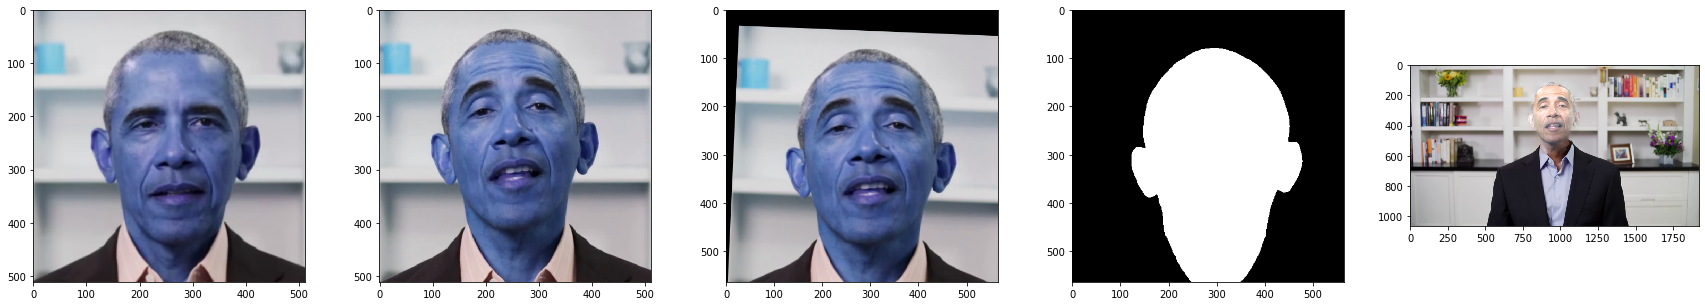

In [18]:
crophd = get_crop_bbox(img, 685,85,1250,650)
crophd = cv2.resize(crophd, (512,512))
synthesis = cv2.imread("/home/vuthede/Desktop/face2.png")

warp2d, cen = align2D(crophd, synthesis)
# warp2d = synthesis.copy()


warp2d_facemask = faceParsing.get_face_mask_512_including_neck(warp2d)
warp2d_facemask = warp2d_facemask.astype(np.uint8)
warp2d_facemask = cv2.resize(warp2d_facemask, (1250-685, 650-85))
warp2d = cv2.resize(warp2d, (1250-685, 650-85))


# center = np.mean(np.where(warp2d_facemask == 255), axis=1)[:2] + [685,85] 
center = cen + [685,85] 
print(cen)
# center= np.array([300,500]) + [685, 85]
center = tuple(center.astype(int))

final_image = cv2.seamlessClone(warp2d[:,:,::-1], result, warp2d_facemask, center, cv2.NORMAL_CLONE)

fig, ax = plt.subplots(1,5,figsize=(30,5))
ax[0].imshow(crophd)
ax[1].imshow(synthesis)
ax[2].imshow(warp2d)
ax[3].imshow(warp2d_facemask)
ax[4].imshow(final_image)




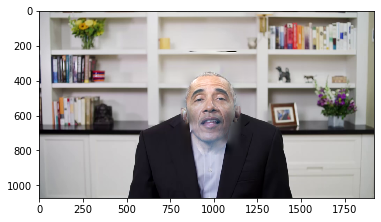

In [15]:
plt.imshow(final_image)


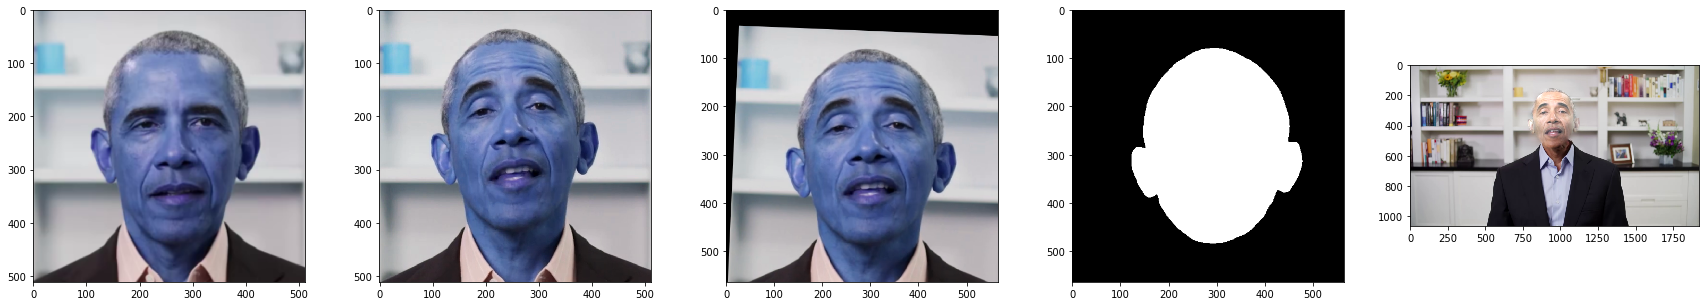

In [19]:
crophd = get_crop_bbox(img, 685,85,1250,650)
crophd = cv2.resize(crophd, (512,512))
synthesis = cv2.imread("/home/vuthede/Desktop/face2.png")

warp2d, cen = align2D(crophd, synthesis)
# warp2d = synthesis.copy()


warp2d_facemask = faceParsing.get_face_mask_512(warp2d)
warp2d_facemask = warp2d_facemask.astype(np.uint8)
warp2d_facemask = cv2.resize(warp2d_facemask, (1250-685, 650-85))
warp2d = cv2.resize(warp2d, (1250-685, 650-85))


# center = np.mean(np.where(warp2d_facemask == 255), axis=1)[:2] + [685,85] 
center = cen + [685,85] 
center = tuple(center.astype(int))

final_image = cv2.seamlessClone(warp2d[:,:,::-1], result, warp2d_facemask, center, cv2.NORMAL_CLONE)

fig, ax = plt.subplots(1,5,figsize=(30,5))
ax[0].imshow(crophd)
ax[1].imshow(synthesis)
ax[2].imshow(warp2d)
ax[3].imshow(warp2d_facemask)
ax[4].imshow(final_image)




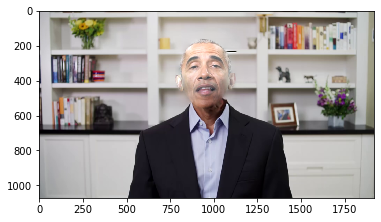

In [22]:
plt.imshow(final_image)
cv2.imshow("s", final_image[:,:,::-1])

if cv2.waitKey(0)==27:
    cv2.destroyAllWindows()

True

usage: ipykernel_launcher.py [-h] [--gpu_ids GPU_IDS]
                             [--batch_size BATCH_SIZE]
                             [--pretrain_model_D PRETRAIN_MODEL_D]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9213 --control=9211 --hb=9210 --Session.signature_scheme="hmac-sha256" --Session.key=b"63eb7a46-5744-4026-b442-81cdaf4b3adf" --shell=9212 --transport="tcp" --iopub=9214 --f=/tmp/tmp-246565psE0aWWkQn.json


SystemExit: 2

In [26]:
%tb

SystemExit: 2

# Test seamless clone

xmin ymin: [21, 207]
mie_crop: [ 56 111]
eye_crop: [ 79 193]
[-23 -82]


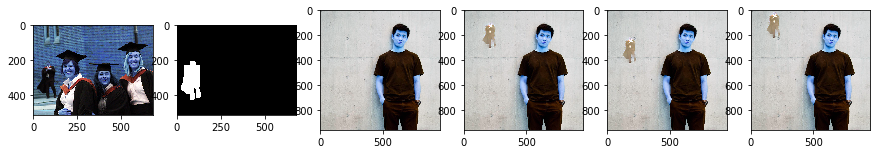

In [39]:
import cv2
import matplotlib.pyplot as plt


src_raw = cv2.imread("/home/vuthede/Desktop/case2_raw.png")
src_mask = cv2.imread("/home/vuthede/Desktop/case2_mask.png")
des_raw = cv2.imread("/home/vuthede/Desktop/Engineer_De Vu.jpg")

fig, ax = plt.subplots(1,6, figsize=(15,5))
ax[0].imshow(src_raw)
ax[1].imshow(src_mask)
ax[2].imshow(des_raw)

index = np.where(src_mask==255)[:2][::-1]
x1,y1 = np.min(index, axis=1)
x2,y2 = np.max(index, axis=1)
mid = np.array([(x1+x2)//2,(y1+y2)//2])
mid_crop = mid-np.array([x1,y1])
a = np.array([100,200])
a_crop = a-np.array([x1,y1])
pad = mid_crop - a_crop
center = tuple(np.array([200,200]) + pad)

blend = cv2.seamlessClone(src_raw, des_raw, src_mask,(200,200), cv2.NORMAL_CLONE)
blend1 = cv2.seamlessClone(src_raw, des_raw, src_mask, center, cv2.NORMAL_CLONE)

# New
eye = np.array([100,400])
eye_crop= eye-np.array([x1,y1])
print("xmin ymin:", [x1, y1])

print("mie_crop:", mid_crop)
print("eye_crop:", eye_crop)

translation =  mid_crop - eye_crop
print(translation)
new_center = np.array([200,200]) + translation
blend2 = cv2.seamlessClone(src_raw, des_raw, src_mask, tuple(new_center), cv2.NORMAL_CLONE)


ax[3].imshow(blend)
ax[4].imshow(blend1)
ax[5].imshow(blend2)



In [22]:
index = np.where(src_mask==255)
index

(array([207, 207, 207, ..., 429, 429, 429]),
 array([78, 78, 78, ..., 90, 90, 90]),
 array([0, 1, 2, ..., 0, 1, 2]))

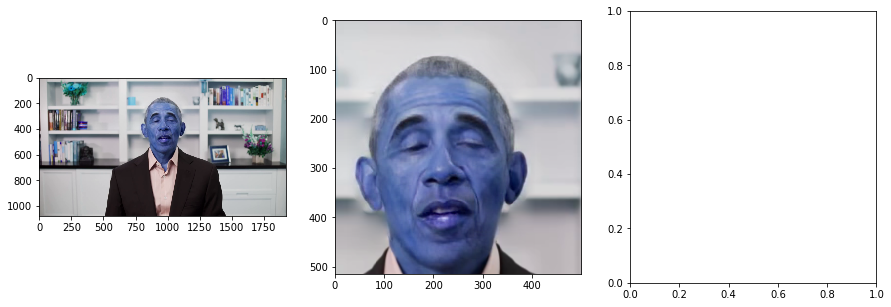

In [17]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/home/vuthede/Desktop/0.png")

x1,y1,x2,y2 = [750,85,1250,600]
cat = img[y1:y2, x1:x2]

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(img)
ax[1].imshow(cat)


In [22]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side


img = cv2.imread("/home/vuthede/Desktop/face2.png")

b,g,r = cv.split(img)
result = ndimage.zoom(img, 0.2)

ax1.imshow(img)
ax2.imshow(result)

plt.show()

TypeError: Invalid shape (102, 102, 1) for image data